#### Training a Single Layer Neural Network with Time Series Data

Now that you've seen statistical methods in the previous week, you will now shift to using neural networks to build your prediction models. You will start with a simple network in this notebook and move on to more complex architectures in the next weeks. By the end of this lab, you will be able to:
- build a single layer network and train it using the same synthetic data you used in the previous lab

- prepare time series data for training and evaluation

- measure the performance of your model against a validation set

#### Imports

You will first import the packages you will need to execute all the code in this lab. You will use:
- Tensorflow to build your model and prepare data windows

- Numpy for numerical processing

- and Matplotlib's PyPlot library for visualization

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### Utilities

These will take care of visualizing your time series data and model predictions, as well as generating the synthetic data.

In [18]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()


def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series


def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern


def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise
    


#### Generate the Synthetic Data

It will contain 1,461 data points that has trend, seasonality, and noise

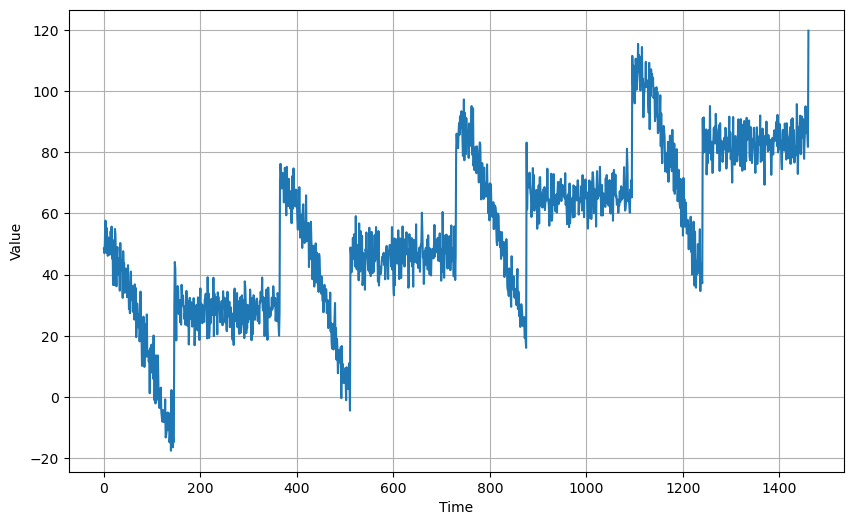

In [19]:
# parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

series += noise(time, noise_level, seed=210)

plot_series(time, series)

#### Split the dataset

In [20]:
split_time = 1000

# train set
time_train = time[:split_time]
x_train = series[:split_time]

# validation test
time_valid = time[split_time:]
x_valid = series[split_time:]

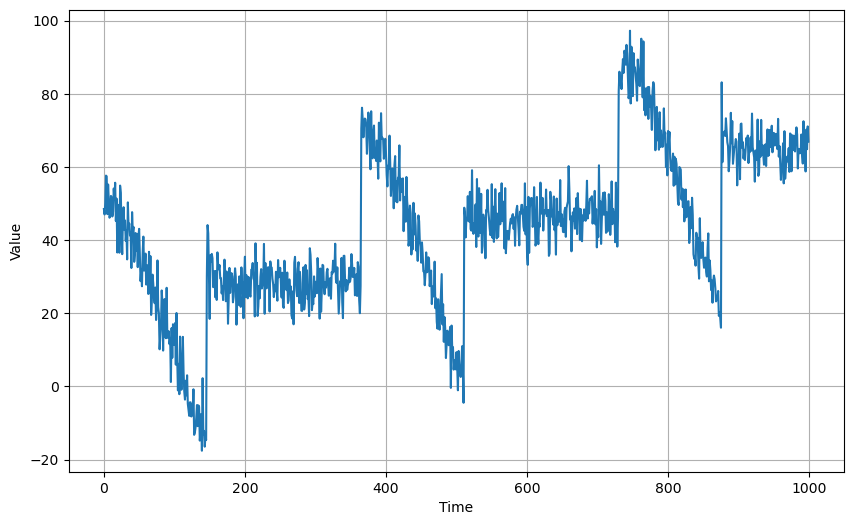

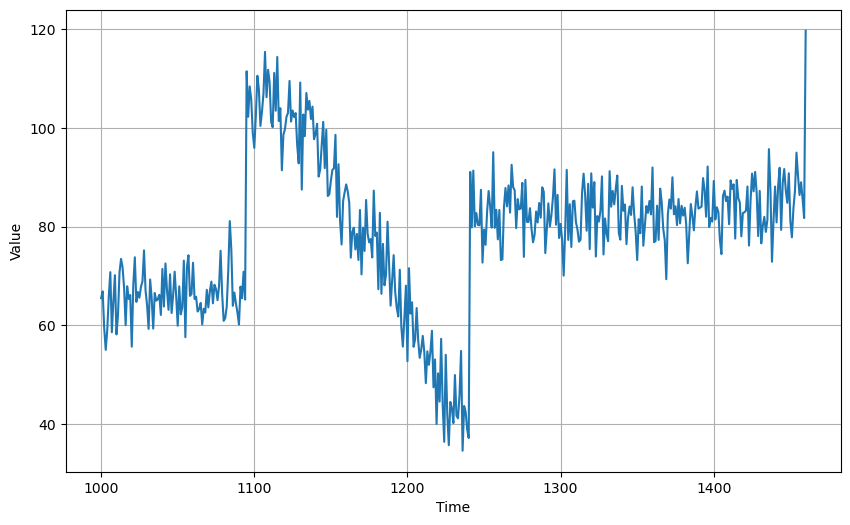

In [21]:
plot_series(time_train, x_train)

plot_series(time_valid, x_valid)

#### Prepare features and labels

In [22]:
# parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

One thing to note here is the `window_size + 1` when you call `dataset.window()`. There is a `+ 1` to indicate that you're taking the next point as the label. For example, the first 20 points will be the feature so the 21st point will be the label.

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [24]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

As expected, it should have a 2-element tuple (i.e. `(feature, label)`) and the shapes of these should align with the batch and window sizes you declared earlier which are `32` and `20` by default, respectively.

In [25]:
# Print properties of a single batch
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


2024-12-18 15:44:37.461054: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-18 15:44:37.463674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Build and compile the model

Next, you will build the single layer neural network. This will just be a one-unit Dense layer as shown below. You will assign the layer to a variable `l0` so you can also look at the final weights later using the `get_weights()` method.

In [28]:
l0 = tf.keras.layers.Dense(1)
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    l0
])

print("Layer weights: \n {} \n".format(l0.get_weights()))

# print the summary
model.summary()

Layer weights: 
 [array([[-0.24783632],
       [-0.28690064],
       [ 0.18756032],
       [-0.24377072],
       [-0.45524454],
       [ 0.19046587],
       [ 0.3832515 ],
       [ 0.42295516],
       [ 0.39825535],
       [-0.21100345],
       [ 0.27854693],
       [-0.1454897 ],
       [-0.49210227],
       [ 0.18555838],
       [-0.51681376],
       [ 0.09539986],
       [ 0.19385654],
       [ 0.04391295],
       [-0.41562432],
       [-0.04705113]], dtype=float32), array([0.], dtype=float32)] 



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)


You will set `mean squared error (mse)` as the loss function and use `stochastic gradient descent (SGD)` to optimize the weights during training.

In [29]:
# set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

#### Train the Model

Now you can proceed to train your model. You will feed in the prepared data windows and run the training for 100 epochs.

In [31]:
# train the model
model.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2260.5527
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 291.2224
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 156.7975
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 140.1960
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 128.9819
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 121.0220
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.8049
Epoch 8/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 84.2988

2024-12-18 15:49:52.234741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.281503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.303936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.325762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.347563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.370082: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109.7458
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 105.4925
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 101.8266
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 98.6113
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 95.7551
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 93.1947
Epoch 14/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90.7479

2024-12-18 15:49:52.480518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.564252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.587527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.610414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.635254: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.659852: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 90.8837
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 88.7864
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 86.8747
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 85.1258
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 83.5203
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 82.0420
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 80.6770
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 79.4134
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 78.2406
Epoch 23/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.1472

2024-12-18 15:49:52.685893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.712676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.736379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.760099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.783120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.808762: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 77.1496
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 76.1324
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 75.1822
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 74.2927
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 73.4587
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 72.6752
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 71.9380
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 71.2436
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 70.5883
Epoch 32/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97.0443

2024-12-18 15:49:52.907256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.930522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.955164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.976939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:52.998903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.023559: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 69.9693
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69.3840
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 68.8298
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 68.3046
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 67.8064
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 67.3336
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 66.8843
Epoch 39/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97.8023

2024-12-18 15:49:53.114309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.190530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.212973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.238207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.261111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.285007: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 66.4573
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 66.0511
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 65.6644
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 65.2963
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 64.9455
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 64.6111
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 64.2923
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 63.9882
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 63.6980
Epoch 48/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98.3889

2024-12-18 15:49:53.335928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.361088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.383546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.407917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.430211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.455021: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 63.4210
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 63.1565
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 62.9038
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 62.6625
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 62.4319
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 62.2114
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.0007
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 61.7992
Epoch 56/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 98.7559

2024-12-18 15:49:53.549518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.575925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.599654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.624915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.648427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.674664: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 61.6066
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61.4222
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - loss: 61.2459
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 61.0772
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 60.9158
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 60.7613
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 60.6134
Epoch 63/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.0282

2024-12-18 15:49:53.758785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.832956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.857758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.881290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.906565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:53.929396: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 60.4718
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 60.3362
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 60.2063
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 60.0820
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 59.9629
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 59.8488
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 59.7395
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 59.6347
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 59.5343
Epoch 72/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99.3458

2024-12-18 15:49:53.980001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.006072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.029416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.054861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.077056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.099579: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 59.4381
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 59.3459
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 59.2575
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 59.1728
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 59.0915
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 59.0136
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 58.9389
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 58.8672
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 58.7984


2024-12-18 15:49:54.196768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.224205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.247334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.273084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.295773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.320817: W tensorflow/core/framework/local_rendezvous.cc:404]

Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.7325
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 58.6692
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 58.6085
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 58.5502
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 58.4943
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 58.4406
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 58.3891
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 58.3396
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 58.2921
Epoch 90/100


2024-12-18 15:49:54.475354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.498930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.525107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.548134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.573788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.597600: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 58.2465
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 58.2027
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 58.1606
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - loss: 58.1202
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.0814 
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 58.0441
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 58.0082
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 57.9738
Epoch 98/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100.1221

2024-12-18 15:49:54.699778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.726076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.748645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.775440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.810941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.834276: W tensorflow/core/framework/local_rendezvous.cc:404]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - loss: 57.9406
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 57.9088
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 57.8782


2024-12-18 15:49:54.909538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.937273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-18 15:49:54.961472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [32]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.0316935 ],
       [-0.05396818],
       [ 0.01683088],
       [-0.00703705],
       [-0.06718396],
       [ 0.02625879],
       [ 0.04496146],
       [ 0.04018662],
       [-0.00824733],
       [-0.02430129],
       [ 0.07129258],
       [-0.05342029],
       [-0.09671917],
       [ 0.0731734 ],
       [-0.03403128],
       [ 0.13648736],
       [ 0.08793259],
       [ 0.1514505 ],
       [ 0.17235081],
       [ 0.4760999 ]], dtype=float32), array([0.01969976], dtype=float32)]


#### Model Prediction

With the training finished, you can now measure the performance of your model. You can generate a model prediction by passing a batch of data windows. If you will be slicing a window from the original `series` array, you will need to add a batch dimension before passing it to the model. That can be done by indexing with the `np.newaxis` constant or using the `np.expand_dims()` method

In [33]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
model prediction: [[42.951153]]


In [35]:
# initialize a list
forecast = []

# use the model ti predicts data points per window size
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis], verbose=0))

forecast = forecast[split_time-window_size:]
# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


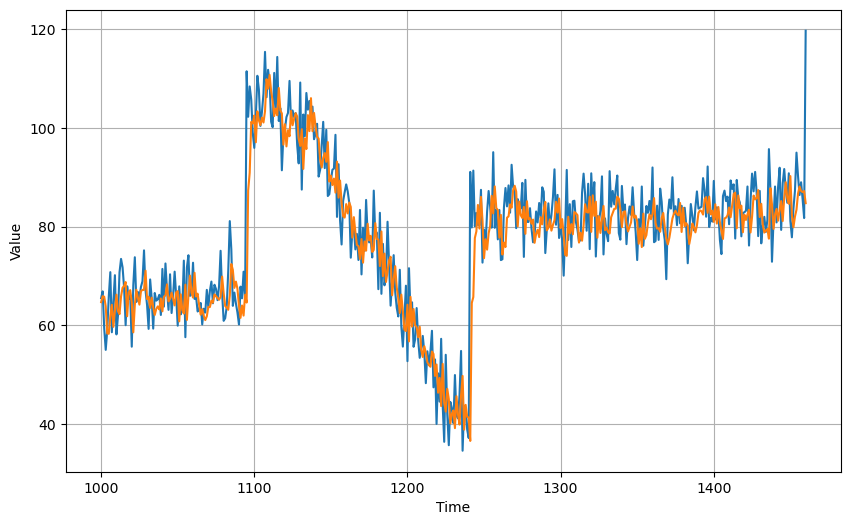

In [36]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [37]:
# Compute the metrics
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

52.479427
5.2365403


#### Wrap Up

In this lab, you were able to build and train a single layer neural network on time series data. You prepared data windows, fed them to the model, and the final predictions show comparable results with the statistical analysis you did in Week 1. In the next labs, you will try adding more layers and will also look at some optimizations you can make when training your model.